# Sampling time

In [2]:
import os
from multiprocessing import Pool

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi

import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pandas as pd
from scipy.spatial import KDTree

import sys
sys.path.append("helpers")

from importlib import reload

import tomFIRE

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load in the data

In [4]:
reload(tomFIRE)
recent_stars = tomFIRE.FIRESnapshot(particle_type="star", min_t_form=13.6 * u.Gyr)
recent_stars

<FIRESnapshot | 9660 star particles | R < 30.0 kpc & t_form > 13.6 Gyr>

In [5]:
pot = gp.load("m11h_potential.yml")

In [6]:
stars_at_formation = pd.read_hdf("FIRE_star_particles.h5", key="df")

# Check nearest neighbours

In [ ]:
stars = tomFIRE.FIRESnapshot(particle_type="star", min_t_form=-1 * u.Gyr)

In [ ]:
tree = KDTree(data=stars.X_s.T)

In [ ]:
d, _ = tree.query(stars.X_s.T, k=2)
d_recent, _ = tree.query(recent_stars.X_s.T, k=2)

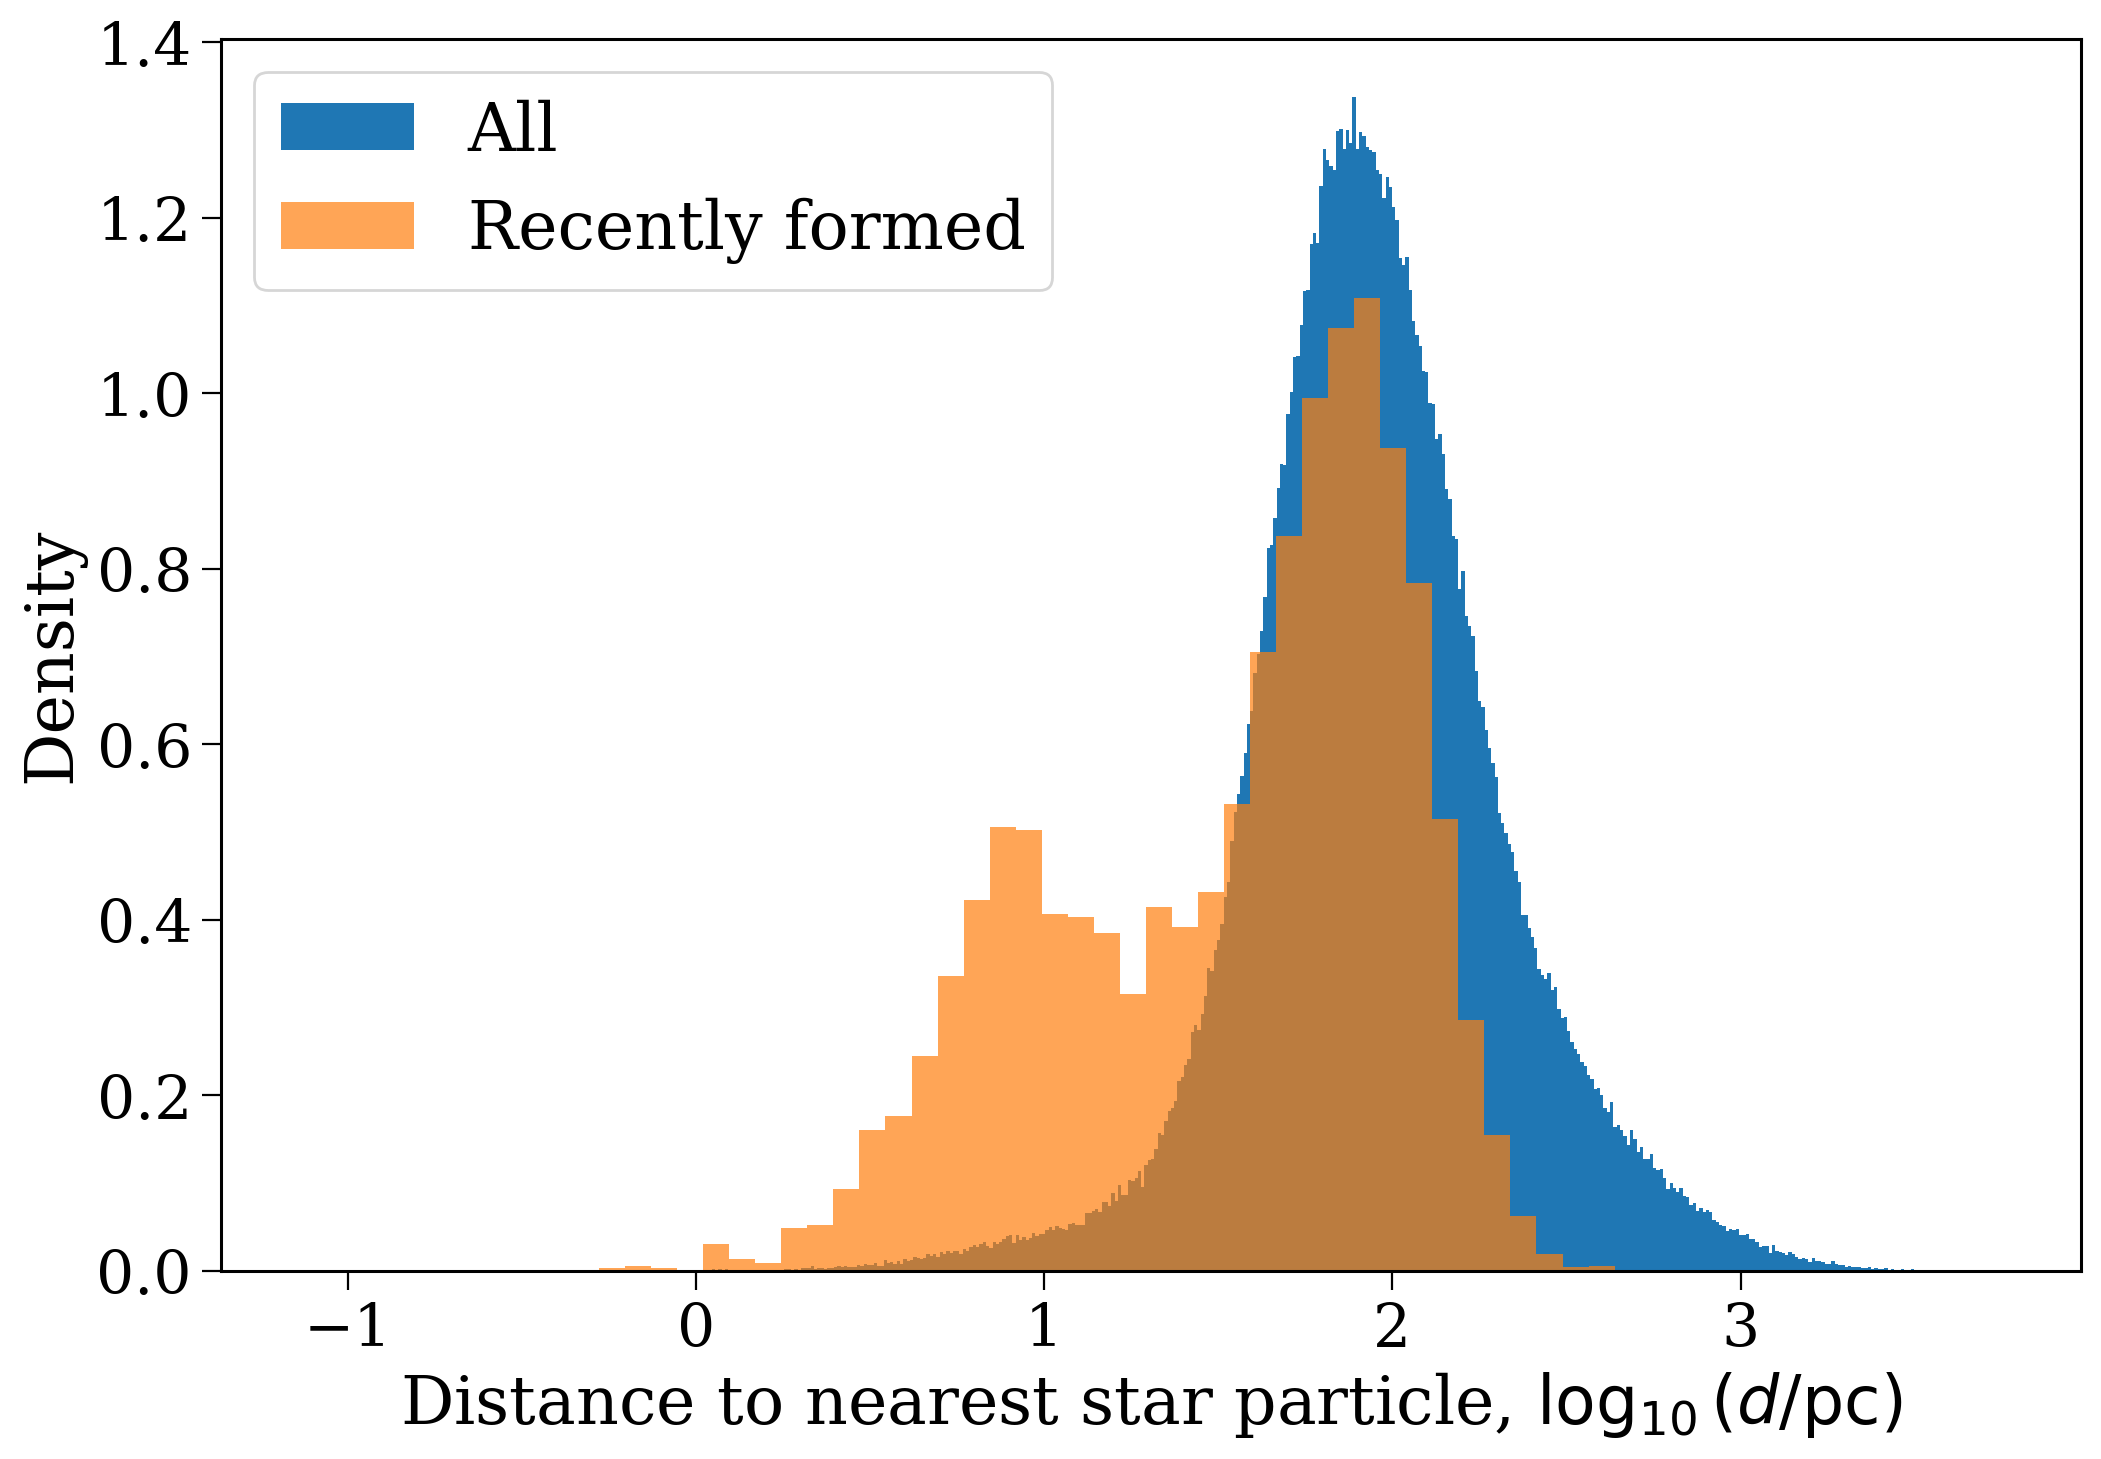

In [ ]:
plt.hist(np.log10(d.max(axis=1) * 1000), bins="fd", density=True, label="All");
plt.hist(np.log10(d_recent.max(axis=1) * 1000), bins="fd", density=True, alpha=0.7, label="Recently formed");
plt.xlabel(r"Distance to nearest star particle, $\log_{10}(d / {\rm pc})$")
plt.ylabel("Density")
plt.legend()

# Design new Population class

In [7]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cogsworth.pop import Population
import cogsworth

In [11]:
class FIREPop(cogsworth.pop.Population):
    def __init__(self, star_particles=None, particle_size=1 * u.pc, particle_boundedness=1.0,
                 sampling_params={"sampling_target": "total_mass",
                                  "trim_extra_samples": True,
                                  "keep_singles": True,}, **kwargs):
        self.star_particles = star_particles
        self.particle_size = particle_size
        self.particle_boundedness = particle_boundedness
        if "n_binaries" not in kwargs:
            kwargs["n_binaries"] = None
        super().__init__(sampling_params=sampling_params, **kwargs)

    def __getitem__(self, ind):
        if self._initC is not None and "particle_id" not in self._initC.columns:
            self._initC["particle_id"] = self._initial_binaries["particle_id"]
        new_pop = super().__getitem__(ind)
        new_pop.star_particles = self.star_particles
        new_pop.particle_size = self.particle_size
        new_pop.particle_boundedness = self.particle_boundedness
        return new_pop
    
    def sample_initial_binaries(self):
        assert self.star_particles is not None,\
            "`self.star_particles` is None, must provide star particles to sample from"
        initial_binaries_list = [None for _ in range(len(self.star_particles))]
        self._mass_singles, self._mass_binaries, self._n_singles_req, self._n_bin_req = 0.0, 0.0, 0, 0

        i = 0
        for id, particle in self.star_particles.iterrows():
            samples = InitialBinaryTable.sampler('independent', np.linspace(0, 15, 16), np.linspace(0, 15, 16),
                                                binfrac_model=self.BSE_settings["binfrac"],
                                                SF_start=self.max_ev_time.to(u.Myr).value - particle["t_form"] * 1000,
                                                SF_duration=0.0, met=particle["Z"],
                                                total_mass=particle["mass"],
                                                size=particle["mass"] * 0.8,
                                                **self.sampling_params)
        
            # apply the mass cutoff and record particle ID
            samples[0].reset_index(inplace=True)
            samples[0].drop(samples[0][samples[0]["mass_1"] < self.m1_cutoff].index, inplace=True)
            samples[0]["particle_id"] = np.repeat(id, len(samples[0]))

            # save samples
            initial_binaries_list[i] = samples[0]
            self._mass_singles += samples[1]
            self._mass_binaries += samples[2]
            self._n_singles_req += samples[3]
            self._n_bin_req += samples[4]

            i += 1

        self._initial_binaries = pd.concat(initial_binaries_list, ignore_index=True)

        self._initial_binaries = self._initial_binaries[self._initial_binaries["mass_1"] >= self.m1_cutoff]

        # same for this class
        self.n_binaries = len(self._initial_binaries)
        self.n_binaries_match = len(self._initial_binaries)

        # ensure metallicities remain in a range valid for COSMIC - original value still in initial_galaxy.Z
        self._initial_binaries.loc[self._initial_binaries["metallicity"] < 1e-4, "metallicity"] = 1e-4
        self._initial_binaries.loc[self._initial_binaries["metallicity"] > 0.03, "metallicity"] = 0.03

        self.sample_initial_galaxy()

    def sample_initial_galaxy(self):
        particles = self.star_particles.loc[self._initial_binaries["particle_id"]]

        x, y, z = np.random.normal([particles["x"].values,
                                    particles["y"].values,
                                    particles["z"].values],
                                    self.particle_size.to(u.kpc).value / np.sqrt(3),
                                    size=(3, self.n_binaries_match)) * u.kpc

        self._initial_galaxy = cogsworth.galaxy.Galaxy(self.n_binaries_match, immediately_sample=False)
        self._initial_galaxy._positions = SkyCoord(x=x, y=y, z=z,
                                                   frame="galactocentric", representation_type="cartesian")
        self._initial_galaxy._tau = self._initial_binaries["tphysf"].values * u.Myr
        self._initial_galaxy._Z = self._initial_binaries["metallicity"].values
        self._initial_galaxy._which_comp = np.repeat("FIRE", len(self.initial_galaxy._tau))

        v_R = (particles["x"] * particles["v_x"]
               + particles["y"] * particles["v_y"])\
            / (particles["x"]**2 + particles["y"]**2)**0.5
        v_T = (particles["x"] * particles["v_y"]
               - particles["y"]*particles["v_x"])\
            / (particles["x"]**2 + particles["y"]**2)**0.5
        v_z = particles["v_z"]

        vel_units = u.km / u.s
        dispersion = dispersion_from_virial_parameter(self.particle_boundedness,
                                                      self.particle_size,
                                                      particles["mass"].values * u.Msun)
        v_R, v_T, v_z = np.random.normal([v_R.values, v_T.values, v_z.values], dispersion / np.sqrt(3),
                                         size=(3, self.n_binaries_match)) * vel_units
        
        self._initial_galaxy._v_R = v_R
        self._initial_galaxy._v_T = v_T
        self._initial_galaxy._v_z = v_z


def dispersion_from_virial_parameter(alpha_vir, R, M):
    return np.sqrt(alpha_vir * const.G * M / (5 * R)).to(u.km / u.s)

In [12]:
p_fire = FIREPop(stars_at_formation.iloc[np.random.choice(len(stars_at_formation), size=10, replace=False)],
                 max_ev_time=recent_stars.snap_time,
                 galactic_potential=pot,
                 m1_cutoff=4)

In [13]:
p_fire.sample_initial_binaries()
p_fire.perform_stellar_evolution()

/mnt/home/twagg/COSMIC/cosmic/utils.py:505: RuntimeWarning: divide by zero encountered in divide
  q = M1 / M2
/mnt/home/twagg/COSMIC/cosmic/utils.py:507: RuntimeWarning: invalid value encountered in divide
  A


In [14]:
ms_stars = (p_fire.final_bpp["kstar_1"] <= 1) | (p_fire.final_bpp["kstar_2"] <= 1)

In [15]:
p = p_fire[ms_stars]

In [16]:
p.perform_galactic_evolution()

100%|██████████| 1143/1143 [00:26<00:00, 42.65it/s]


In [18]:
60 * 4 / 32 / 10 * len(stars_at_formation) / 60 / 60

2.0125

In [11]:
p.create_population()

Run for None binaries
Ended up with 423 binaries with m1 > 4 solar masses
[5e-01s] Sample initial binaries


/mnt/home/twagg/COSMIC/cosmic/utils.py:505: RuntimeWarning: divide by zero encountered in divide
  q = M1 / M2
/mnt/home/twagg/COSMIC/cosmic/utils.py:507: RuntimeWarning: invalid value encountered in divide
  A


[1.2s] Evolve binaries (run COSMIC)


100%|██████████| 423/423 [00:15<00:00, 27.23it/s]  


[19.2s] Get orbits (run gala)
Overall: 20.9s


In [112]:
first_star_particle = p._initial_binaries["particle_id"] == p._initial_binaries["particle_id"].iloc[-1]
p_fsp = p[p.bin_nums[first_star_particle]]
ms_stars = (p_fsp.final_bpp["kstar_1"] == 1) | (p_fsp.final_bpp["kstar_2"] == 1)
kicked_bin_nums = p_fsp.bpp[p_fsp.bpp["evol_type"].isin([15, 16])]["bin_num"].unique()

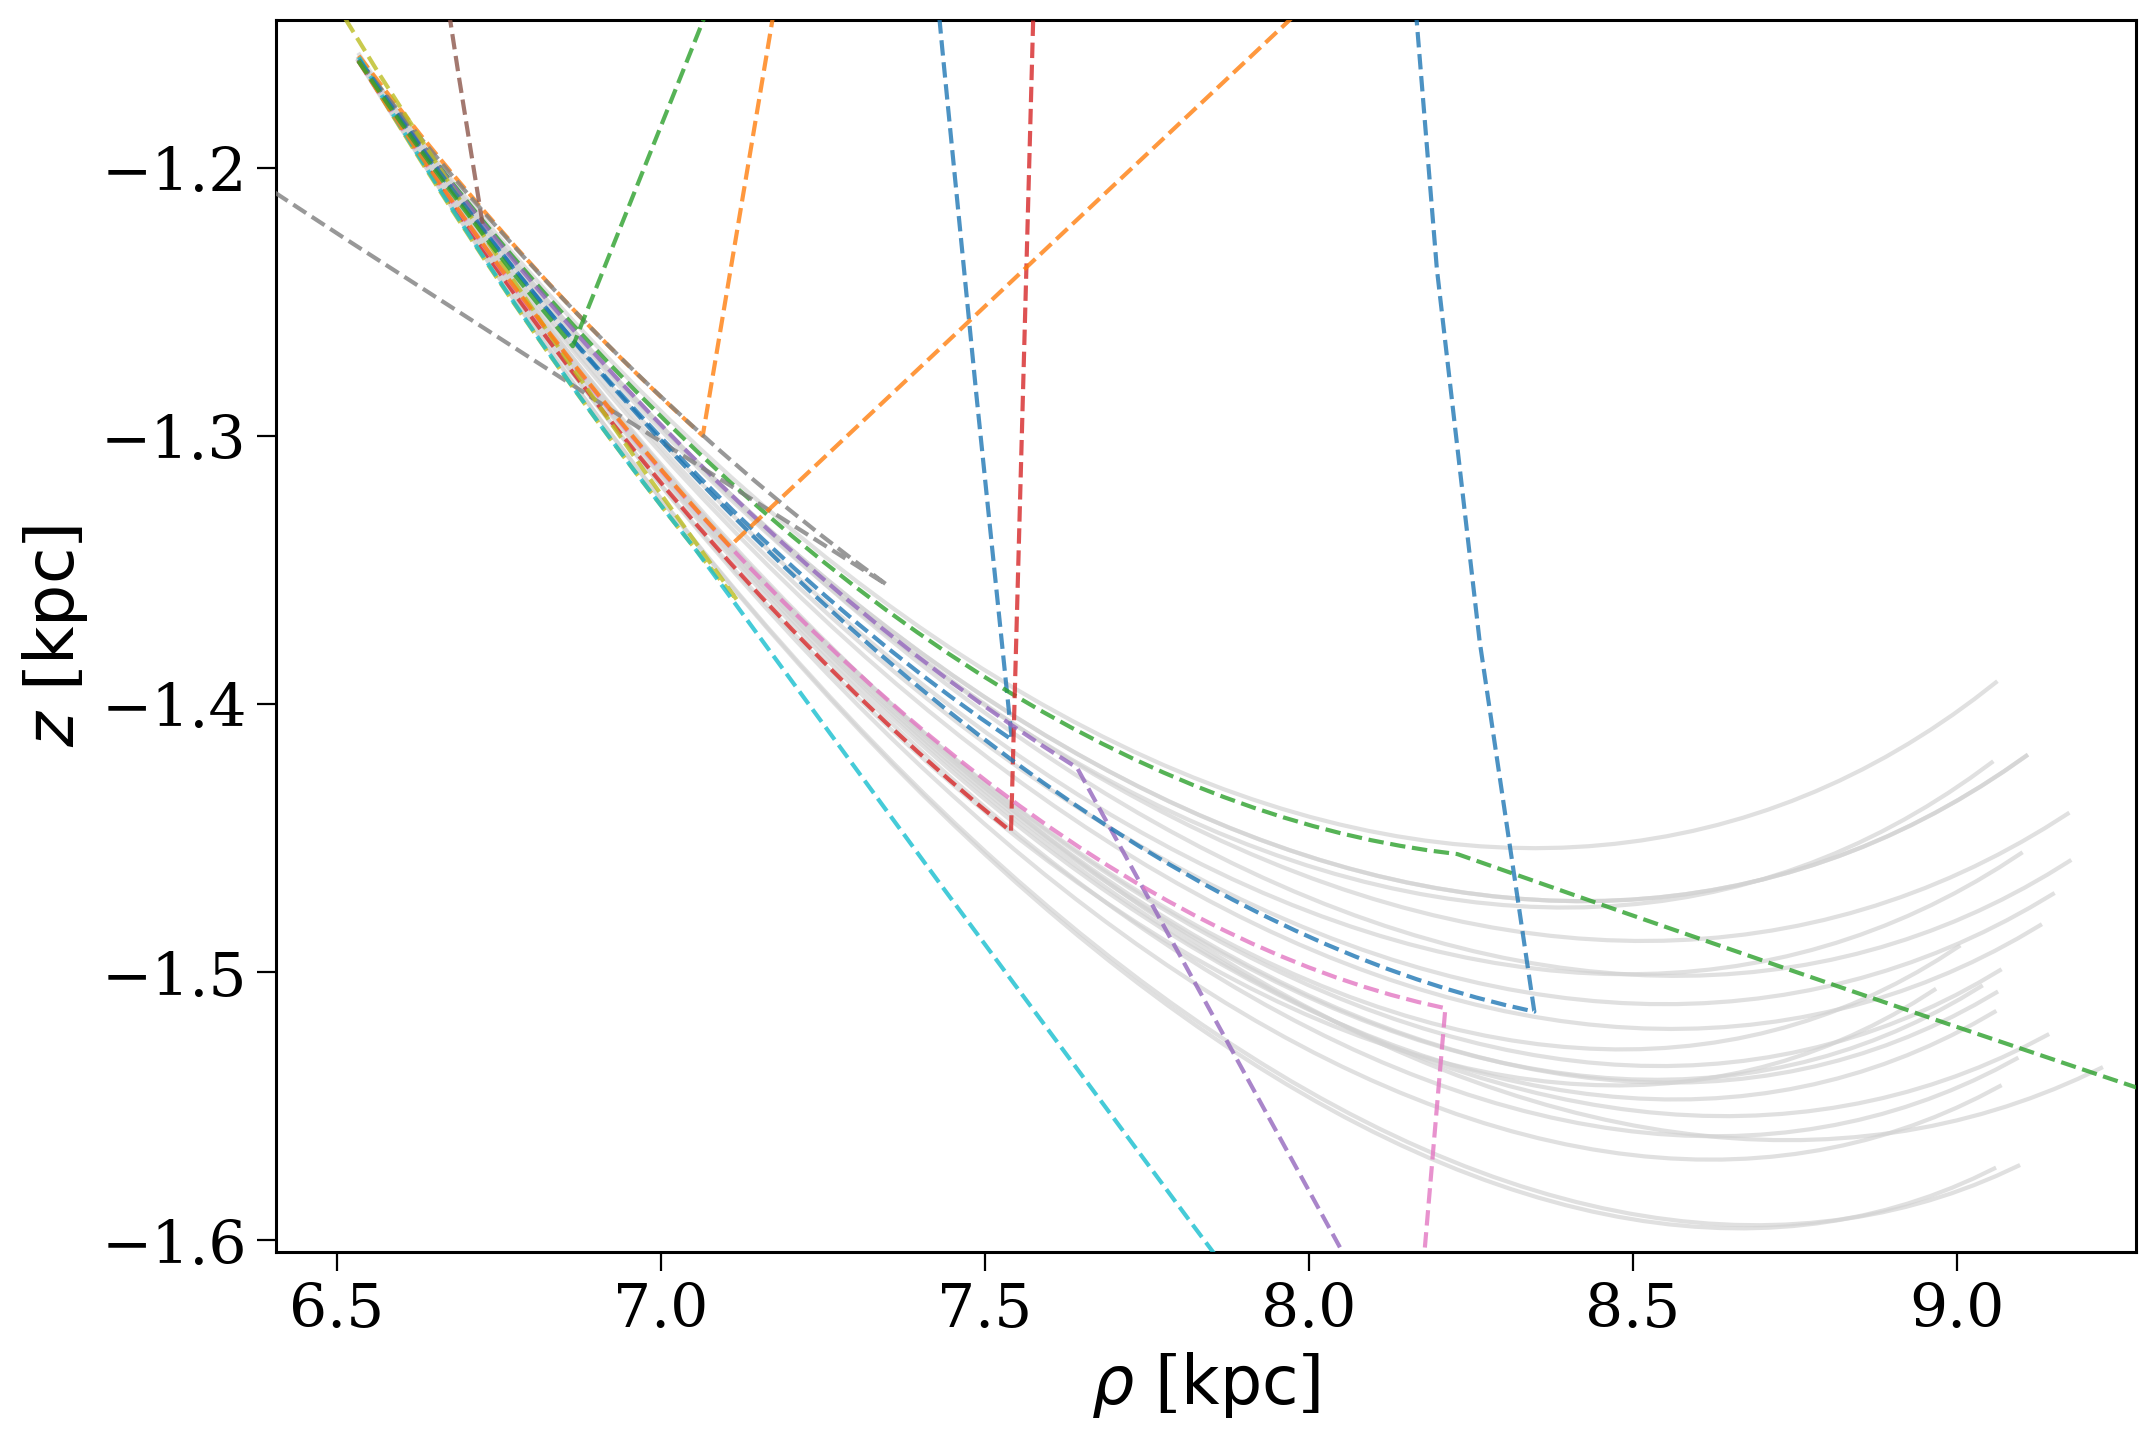

In [114]:
fig, ax = plt.subplots()
cluster_style = {
    "color": "lightgrey",
    "zorder": -1,
    "linestyle": "-",
    "alpha": 0.7,
    "autolim": True
}
supernova_style = {
    "color": None,
    "zorder": 10,
    "linestyle": "--",
    "alpha": 0.8,
    "autolim": False
}
p_fsp.orbits[ms_stars][0].cylindrical.plot(["rho", "z"], axes=ax, **cluster_style);
for bin_num, orbit in zip(p_fsp.bin_nums, p_fsp.orbits):
    style = supernova_style if bin_num in kicked_bin_nums else cluster_style
    orbit.cylindrical.plot(["rho", "z"], axes=ax, **style);

plt.show()

In [53]:
p.save("test", overwrite=True)

100%|██████████| 206/206 [00:04<00:00, 44.08it/s]


In [58]:
a1 = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/boundedness/alpha_1.0")

In [64]:
((a1.final_bpp["kstar_1"] < 15) & (a1.final_bpp["kstar_2"] < 15)).sum()

10134

In [90]:
test = FIREPop(stars_at_formation.iloc[np.random.choice(len(stars_at_formation), size=10, replace=False)],
        max_ev_time=recent_stars.snap_time,
        galactic_potential=pot,
        m1_cutoff=4)

In [91]:
x = test.sample_initial_binaries()

12205
227
227
11174
221
221
11770
215
215
17538
356
356
11068
209
209
9895
191
191
10256
169
169
12405
248
248
14280
278
278
11071
209
209

 2323

 2323


In [93]:
is_single = test._initial_binaries["kstar_2"] == 15

In [94]:
is_single.sum()

1145

In [95]:
len(test._initial_binaries)

2323